<a href="https://colab.research.google.com/github/Swastik3025/Polygon_Coloring_with_Unet/blob/main/Ayna_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setting up Environment

In [30]:
pip install torch torchvision wandb

## Download and extract dataset



In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os

zip_path = '/content/drive/MyDrive/dataset.zip'

extract_dir = '/content/'

# Check whether the zip file exists
if os.path.exists(zip_path):
    # Unzipping the dataset
    !unzip -q "{zip_path}" -d "{extract_dir}"
    print("Dataset extracted successfully.")
else:
    # throwing error if the data set is not present in the Source
    print(f"Error: {zip_path} not found in your Google Drive.")

replace /content/dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Dataset extracted successfully.


## Explore dataset

In [33]:
import json

dataset_path = '/content/dataset'
training_path = os.path.join(dataset_path, 'training')
validation_path = os.path.join(dataset_path, 'validation')

# Inspect the contents of the training and validation directories
print("Training directory contents:", os.listdir(training_path))
print("Validation directory contents:", os.listdir(validation_path))

# Load and inspect the data.json files
with open(os.path.join(training_path, 'data.json'), 'r') as f:
    training_data = json.load(f)
print("\nTraining data.json structure (first 5 entries):")
for i, entry in enumerate(training_data):
    if i < 5:
        print(f"Entry {i}: {entry}")
    else:
        break

with open(os.path.join(validation_path, 'data.json'), 'r') as f:
    validation_data = json.load(f)
print("\nValidation data.json structure (first 5 entries):")
for i, entry in enumerate(validation_data):
    if i < 5:
        print(f"Entry {i}: {entry}")
    else:
        break


# Inspect image file names in input and output directories (first 5)
print("\nTraining input images (first 5):", os.listdir(os.path.join(training_path, 'inputs'))[:5])
print("Training output images (first 5):", os.listdir(os.path.join(training_path, 'outputs'))[:5])
print("Validation input images (first 5):", os.listdir(os.path.join(validation_path, 'inputs'))[:5])
print("Validation output images (first 5):", os.listdir(os.path.join(validation_path, 'outputs'))[:5])

Training directory contents: ['outputs', 'inputs', 'data.json']
Validation directory contents: ['outputs', 'inputs', 'data.json']

Training data.json structure (first 5 entries):
Entry 0: {'input_polygon': 'octagon.png', 'colour': 'cyan', 'output_image': 'cyan_octagon.png'}
Entry 1: {'input_polygon': 'square.png', 'colour': 'purple', 'output_image': 'purple_square.png'}
Entry 2: {'input_polygon': 'hexagon.png', 'colour': 'magenta', 'output_image': 'magenta_hexagon.png'}
Entry 3: {'input_polygon': 'square.png', 'colour': 'magenta', 'output_image': 'magenta_square.png'}
Entry 4: {'input_polygon': 'hexagon.png', 'colour': 'purple', 'output_image': 'purple_hexagon.png'}

Validation data.json structure (first 5 entries):
Entry 0: {'input_polygon': 'star.png', 'colour': 'yellow', 'output_image': 'yellow_star.png'}
Entry 1: {'input_polygon': 'triangle.png', 'colour': 'green', 'output_image': 'green_triangle.png'}
Entry 2: {'input_polygon': 'octagon.png', 'colour': 'blue', 'output_image': 'blu

## Implementing Custom Dataset and DataLoader



In [34]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class PolygonDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform

        with open(os.path.join(data_path, 'data.json'), 'r') as f:
            self.data = json.load(f)

        self.input_dir = os.path.join(data_path, 'inputs')
        self.output_dir = os.path.join(data_path, 'outputs')

        # Embeddings/Mappings for the colours
        self.color_mapping = {
            "red": [1, 0, 0, 0, 0, 0],
            "green": [0, 1, 0, 0, 0, 0],
            "blue": [0, 0, 1, 0, 0, 0],
            "cyan": [0, 0, 0, 1, 0, 0],
            "magenta": [0, 0, 0, 0, 1, 0],
            "yellow": [0, 0, 0, 0, 0, 1]
        }


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        input_filename = entry['input_polygon']
        output_filename = entry['output_image']
        color_name = entry['colour']

        input_image_path = os.path.join(self.input_dir, input_filename)
        output_image_path = os.path.join(self.output_dir, output_filename)

        input_image = Image.open(input_image_path).convert('RGB')
        output_image = Image.open(output_image_path).convert('RGB')

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        # Convert color name to numerical representation
        color_vector = torch.tensor(self.color_mapping.get(color_name, [0] * 6), dtype=torch.float32) # Default to zero vector if color not found

        return input_image, color_vector, output_image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize images to a fixed size
    transforms.ToTensor(),       # Convert images to PyTorch tensors
])

# Creating dataset instances
train_dataset = PolygonDataset(data_path='/content/dataset/training', transform=transform)
val_dataset = PolygonDataset(data_path='/content/dataset/validation', transform=transform)

# Creating DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Dataset and DataLoader created successfully.")
print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))

# Example of accessing a batch of data
input_images, color_vectors, output_images = next(iter(train_dataloader))
print("\nExample batch shapes:")
print("Input images shape:", input_images.shape)
print("Color vectors shape:", color_vectors.shape)
print("Output images shape:", output_images.shape)

Dataset and DataLoader created successfully.
Number of training samples: 56
Number of validation samples: 5

Example batch shapes:
Input images shape: torch.Size([32, 3, 256, 256])
Color vectors shape: torch.Size([32, 6])
Output images shape: torch.Size([32, 3, 256, 256])


## Implementing UNet Model

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downsampling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upsampling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_colors, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_colors = n_colors
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels + n_colors, 64) # Adjust input channels to include color info
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024 + 512, 512, bilinear)
        self.up2 = Up(512 + 256, 256, bilinear)
        self.up3 = Up(256 + 128, 128, bilinear)
        self.up4 = Up(128 + 64, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x, colors):
        # Expand color vector to match image dimensions
        colors = colors.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, colors], dim=1) # Concatenate image and color info along channel dimension

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Example usage:
# Assuming input image has 3 channels (RGB) and output has 3 channels (RGB)
# and color vector has 6 elements
model = UNet(n_channels=3, n_classes=3, n_colors=6)
print("UNet model created successfully.")
print(model)

UNet model created successfully.
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): B

## Setting up Weights & Biases


In [36]:
import wandb

# Initialize wandb
wandb.init(project="Ayna_Assignment")

# Log hyperparameters and configuration
config = wandb.config
config.learning_rate = 0.001
config.epochs = 50
config.batch_size = 32

print("Weights & Biases initialized.")

epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
epoch_train_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▅█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
epoch_train_loss,0.01638
val_loss,0.04081


Weights & Biases initialized.


## Defining Loss and Optimizer for the task

In [37]:
import torch.optim as optim

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

print("Loss function and optimizer defined.")

Loss function and optimizer defined.


## Train the Model


In [38]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement in validation loss
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop
for epoch in range(config.epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for i, (inputs, colors, outputs) in enumerate(train_dataloader):
        # Move data to the appropriate device
        inputs, colors, outputs = inputs.to(device), colors.to(device), outputs.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        predicted_outputs = model(inputs, colors)

        # Calculate loss
        loss = criterion(predicted_outputs, outputs)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        # Log batch training loss to wandb
        if (i + 1) % 10 == 0:  # Log every 10 mini-batches
            wandb.log({"train_batch_loss": running_loss / 10})
            running_loss = 0.0

    # Log epoch training loss
    epoch_train_loss = running_loss / len(train_dataloader) if len(train_dataloader) > 0 else 0.0
    print(f'Epoch [{epoch + 1}/{config.epochs}] finished. Average Training Loss: {epoch_train_loss:.4f}')
    wandb.log({"epoch_train_loss": epoch_train_loss, "epoch": epoch + 1})

    # Evaluate the model on the validation set after each epoch
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, colors, outputs in val_dataloader:
            # Move data to the appropriate device
            inputs, colors, outputs = inputs.to(device), colors.to(device), outputs.to(device)

            # Forward pass
            predicted_outputs = model(inputs, colors)

            # Calculate loss
            loss = criterion(predicted_outputs, outputs)

            running_val_loss += loss.item()

    # Calculate and log validation loss for the epoch
    val_loss = running_val_loss / len(val_dataloader) if len(val_dataloader) > 0 else 0.0
    print(f'Epoch [{epoch + 1}/{config.epochs}] Validation Loss: {val_loss:.4f}')
    wandb.log({"val_loss": val_loss, "epoch": epoch + 1})

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Optionally save the best model state
        torch.save(model.state_dict(), 'best_unet_polygon_coloring_model.pth')
        print("Saved best model.")
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve for {epochs_without_improvement} epochs.")
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch + 1} epochs due to no improvement in validation loss.")
            break # Stop training loop

print("Finished Training")

Epoch [1/50] finished. Average Training Loss: 1.0822
Epoch [1/50] Validation Loss: 0.9279
Saved best model.
Epoch [2/50] finished. Average Training Loss: 0.7537
Epoch [2/50] Validation Loss: 0.9160
Saved best model.
Epoch [3/50] finished. Average Training Loss: 0.5504
Epoch [3/50] Validation Loss: 1.8176
Validation loss did not improve for 1 epochs.
Epoch [4/50] finished. Average Training Loss: 0.4460
Epoch [4/50] Validation Loss: 7.8900
Validation loss did not improve for 2 epochs.
Epoch [5/50] finished. Average Training Loss: 0.3686
Epoch [5/50] Validation Loss: 2.8603
Validation loss did not improve for 3 epochs.
Epoch [6/50] finished. Average Training Loss: 0.3008
Epoch [6/50] Validation Loss: 0.8409
Saved best model.
Epoch [7/50] finished. Average Training Loss: 0.2693
Epoch [7/50] Validation Loss: 0.5507
Saved best model.
Epoch [8/50] finished. Average Training Loss: 0.2098
Epoch [8/50] Validation Loss: 0.4581
Saved best model.
Epoch [9/50] finished. Average Training Loss: 0.1882

## Evaluate the Model


In [39]:
# Evaluate the model on the validation set
model.eval()  # Set the model to evaluation mode
running_val_loss = 0.0
with torch.no_grad():  # Disable gradient calculation during evaluation
    for inputs, colors, outputs in val_dataloader:
        # Move data to the appropriate device
        inputs, colors, outputs = inputs.to(device), colors.to(device), outputs.to(device)

        # Forward pass
        predicted_outputs = model(inputs, colors)

        # Calculate loss
        loss = criterion(predicted_outputs, outputs)

        running_val_loss += loss.item()

# Log validation loss
val_loss = running_val_loss / len(val_dataloader)
print(f'\nValidation Loss: {val_loss:.4f}')
wandb.log({"val_loss": val_loss})

print("Finished Evaluation")


Validation Loss: 0.0473
Finished Evaluation


## Saving the trained model


In [40]:
# Define the path to save the model
model_save_path = 'best_unet_polygon_coloring_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to Ayna_assignment.pth


# Polygon Coloring Inference

## Load the trained model

First, we need to load the saved model weights.

In [41]:
from PIL import Image

import matplotlib.pyplot as plt


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downsampling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upsampling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_colors, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_colors = n_colors
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels + n_colors, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024 + 512, 512, bilinear)
        self.up2 = Up(512 + 256, 256, bilinear)
        self.up3 = Up(256 + 128, 128, bilinear)
        self.up4 = Up(128 + 64, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x, colors):
        colors = colors.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, colors], dim=1)

        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# Path to the saved model
model_save_path = 'best_unet_polygon_coloring_model.pth'

# Initialize the model
# Make sure the parameters match the trained model
model = UNet(n_channels=3, n_classes=3, n_colors=6)

# Load the saved state dictionary
model.load_state_dict(torch.load(model_save_path))

# Set the model to evaluation mode
model.eval()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Model loaded successfully from {model_save_path}")

Model loaded successfully from best_unet_polygon_coloring_model.pth


## Perform Inference

Now we can use the loaded model to color a polygon image.

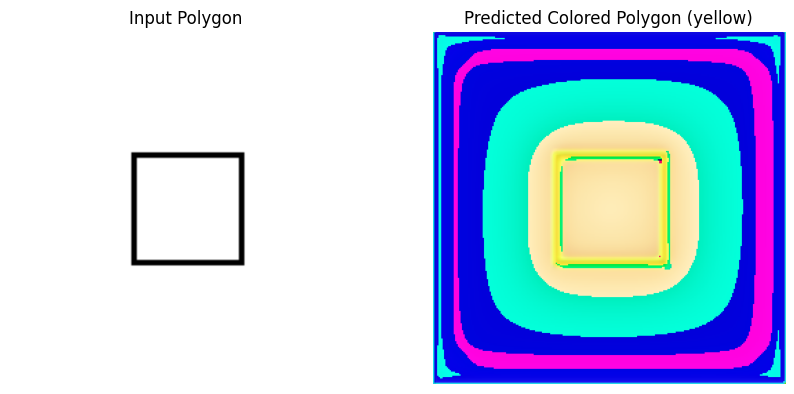

In [42]:
# Define the path to an input image and the desired color
input_image_path = '/content/dataset/validation/inputs/square.png' # Example input image
desired_color_name = 'yellow' # Example color

# Define the same transform used during training
transform = transforms.Compose([
    transforms.Resize((256, 256)), # Resize images to a fixed size
    transforms.ToTensor(),       # Convert images to PyTorch tensors
])

# Load and preprocess the input image
input_image = Image.open(input_image_path).convert('RGB')
input_tensor = transform(input_image).unsqueeze(0).to(device) # Add batch dimension and move to device

# Define the color mapping (must match the one used during training)
color_mapping = {
    "red": [1, 0, 0, 0, 0, 0],
    "green": [0, 1, 0, 0, 0, 0],
    "blue": [0, 0, 1, 0, 0, 0],
    "cyan": [0, 0, 0, 1, 0, 0],
    "magenta": [0, 0, 0, 0, 1, 0],
    "yellow": [0, 0, 0, 0, 0, 1]
}

# Convert the desired color name to its numerical representation
color_vector = torch.tensor(color_mapping.get(desired_color_name, [0] * 6), dtype=torch.float32).unsqueeze(0).to(device) # Add batch dimension and move to device

# Perform inference
with torch.no_grad():
    predicted_output_tensor = model(input_tensor, color_vector)

# Post-process the output tensor
predicted_output_tensor = predicted_output_tensor.squeeze(0).cpu() # Remove batch dimension and move to CPU
predicted_output_image = transforms.ToPILImage()(predicted_output_tensor)

# Display the input image and the predicted output image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(input_image)
axes[0].set_title('Input Polygon')
axes[0].axis('off')

axes[1].imshow(predicted_output_image)
axes[1].set_title(f'Predicted Colored Polygon ({desired_color_name})')
axes[1].axis('off')

plt.show()